# Quais são as preferências dos passageiros e o impacto de fatores externos nas corridas ?

# Contents <a id='back'></a>

* [Introdução](#intro)
* [Etapa 1. Visão geral dos dados](#data_review)
    * [Primeiras conclusões](#data_review_conclusions)
* [Etapa 2. Pré-processamento de dados](#data_preprocessing)
    * [2.1 Duplicatas](#duplicates)
    * [2.2 Conclusões intermediárias](#data_preprocessing_conclusions_intermediary)
* [Etapa 3. Transformações dos dados](#tranforamation_data)
* [Etapa 4. EDA](#eda)
* [Etapa 5. Hipóteses](#hypothesys)
* [Conclusões](#end)

## Introdução <a id='intro'></a>

Foi conduzido um estudo de banco de dados para analisar os dados dos concorrentes e testar uma hipótese sobre o impacto do clima na frequência de corridas

### Objetivo: 
 - importar os arquivos
 - estudar os dados que eles contêm
 - verificar se os tipos de dados estão corretos
 - identificar os 10 principais bairros em termos de destinos
 - fazer gráficos: empresas de táxi e número de corridas, top 10 bairros por número de corridas em que esse bairro é destino
 - tirar conclusões com base em cada gráfico e explicar os resultados
 
 ### Etapas 
- `Os dados sobre o comportamento do usuário é armazenado no arquivo`  

/datasets/project_sql_result_01.csv. contém os seguintes dados:
- `trips_amount: o número de corridas para cada empresa de táxi de 15 a 16 de novembro de 2017.` 


/datasets/project_sql_result_04.csv. contém os seguintes dados:
- `dropoff_location_name: bairros de Chicago onde as corridas terminaram`
- `average_trips: o número médio de viagens que terminaram em cada bairro em novembro de 2017.` 


/datasets/project_sql_result_07.csv — o resultado da última consulta. 

Ele contém dados sobre viagens do Loop para o Aeroporto Internacional O'Hare. Lembre-se, estes são os valores dos campos da tabela:  
- `start_ts`
- `data e hora de coleta`
- `weather_conditions`
- `condições meteorológicas no momento em que a corrida começou`
- `duration_seconds`
- `duração da corrida em segundos`

Primeiro, você avaliará a qualidade dos dados e ver se seus problemas são significativos. Depois, durante o pré-processamento de dados, você tentará dar conta dos problemas mais críticos problemas.
 
O seu projeto consistirá em cinco etapas:
 1. Visão geral dos dados
 2. Pré-processamento de dados
 3. Transformações dos dados
 4. EDA
 5. Teste as hipóteses:
"A duração média dos passeios do Loop para o Aeroporto Internacional O'Hare muda nos sábados chuvosos." 
Decida onde definir o nível de significância (alfa) por conta própria.
Explique:
como você formou as hipóteses nula e alternativa
qual critério você usou para testar a hipótese e porque

[Voltar ao Índice](#back)

## Etapa 1. Visão geral dos dados <a id='data_review'></a>

Carregue os dados das consultas, explore-os e carregue bibliotecas que você acredita que são necessárias para o projeto.

In [1]:
# Carregando todas as bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Carregue o arquivo com os dados em um DataFrame
df_company = pd.read_csv('C:/Users/gabri/Downloads/Corrigido/Projeto 6/project_sql_result_01.csv')
df_location = pd.read_csv('C:/Users/gabri/Downloads/Corrigido/Projeto 6/project_sql_result_04.csv')
df_weather = pd.read_csv('C:/Users/gabri/Downloads/Corrigido/Projeto 6/project_sql_result_07.csv')

In [3]:
def print_dataframe_info(dataframes):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print(df_name)
        print(df.info())
        print()
        print('-------------------------------------------')
        print()

print_dataframe_info([df_company, df_location, df_weather])

df_company
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   company_name  64 non-null     object
 1   trips_amount  64 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 1.1+ KB
None

-------------------------------------------

df_location
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   dropoff_location_name  94 non-null     object 
 1   average_trips          94 non-null     float64
dtypes: float64(1), object(1)
memory usage: 1.6+ KB
None

-------------------------------------------

df_weather
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1068 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --

In [4]:
df_company.head()

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299


In [5]:
df_location.head()

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000


In [6]:
df_weather.head()

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


### Primeiras conclusões <a id='data_review_conclusions'></a> 

Não observamos a presença de valores ausentes em algumas colunas, e não identificamos nenhum erro relacionado ao estilo dessas colunas. A fim de garantir a integridade de nossa pesquisa, faremos uma investigação mais detalhada para lidar com essa situação.

[Voltar ao Índice](#back)

## Etapa 2. Pré-processar dados <a id='data_preprocessing'></a>

### Duplicatas <a id='duplicates'></a>
Encontrando de duplicatas óbvias na tabela usando um comando:

In [7]:
dataframes_dict = {f"df_{i}": df for i, df in enumerate([df_company, df_location, df_weather])}

In [8]:
for name, df in dataframes_dict.items():
    duplicate_values = df.duplicated().sum()
    print(f"DataFrame: {name}")
    print(f"Valores duplicados: {duplicate_values}")
    print('-------------------------------------------')

DataFrame: df_0
Valores duplicados: 0
-------------------------------------------
DataFrame: df_1
Valores duplicados: 0
-------------------------------------------
DataFrame: df_2
Valores duplicados: 197
-------------------------------------------


In [9]:
#verificando porcentagem de duplicatas
(df_weather.duplicated().sum() / df_weather.shape[0]) * 100

18.44569288389513

In [10]:
# removendo duplicatas óbvias
df_weather = df_weather.drop_duplicates()

Em relação à tabela de weather, observamos que 18,5% dos dados estão duplicados. Essas duplicatas foram removidas. Quanto às demais tabelas, não foram identificadas duplicatas ou valores ausentes.

[Voltar ao Índice](#back)

### Conclusões intermediárias <a id='data_preprocessing_conclusions_intermediary'></a>

Após uma análise detalhada, constatamos que as demais colunas estão em conformidade com as expectativas. Agora, procederemos à verificação e correção dos tipos de dados presentes no conjunto de dados.

## Etapa 3. Transformação de dados <a id='tranforamation_data'></a>
Vamos examinar cada coluna para ver quais problemas podemos ter nelas.

In [11]:
df_company['company_name'].sort_values().unique()

array(['0118 - 42111 Godfrey S.Awir', '1085 - 72312 N and W Cab Co',
       '1469 - 64126 Omar Jada', '2092 - 61288 Sbeih company',
       '2192 - 73487 Zeymane Corp',
       '2241 - 44667 - Felman Corp, Manuel Alonso', '24 Seven Taxi',
       '2733 - 74600 Benny Jona', '2809 - 95474 C & D Cab Co Inc.',
       '2823 - 73307 Lee Express Inc', '3011 - 66308 JBL Cab Inc.',
       '303 Taxi', '3556 - 36214 RC Andrews Cab',
       '3591 - 63480 Chuks Cab', '3620 - 52292 David K. Cab Corp.',
       '3623 - 72222 Arrington Enterprises',
       '3721 - Santamaria Express, Alvaro Santamaria',
       '4053 - 40193 Adwar H. Nikola', '4615 - 83503 Tyrone Henderson',
       '4623 - 27290 Jay Kim', '5 Star Taxi', '5006 - 39261 Salifu Bawa',
       '5062 - 34841 Sam Mestas', '5074 - 54002 Ahzmi Inc',
       '5874 - 73628 Sergey Cab Corp.', '5997 - 65283 AW Services Inc.',
       '6057 - 24657 Richard Addo', '6574 - Babylon Express Inc.',
       '6742 - 83735 Tasha ride inc', '6743 - 78771 Luhak Corp'

In [12]:
df_location['dropoff_location_name'].sort_values().unique()

array(['Albany Park', 'Andersonville', 'Archer Heights', 'Armour Square',
       'Ashburn', 'Auburn Gresham', 'Austin', 'Avalon Park', 'Avondale',
       'Belmont Cragin', 'Beverly', 'Boystown', 'Bridgeport',
       'Brighton Park', 'Bucktown', 'Burnside', 'Calumet Heights',
       'Chatham', 'Chicago Lawn', 'Chinatown', 'Clearing', 'Douglas',
       'Dunning', 'East Side', 'East Village', 'Edgewater', 'Edison Park',
       'Englewood', 'Fuller Park', 'Gage Park', 'Garfield Park',
       'Garfield Ridge', 'Gold Coast', 'Grand Boulevard',
       'Grand Crossing', 'Grant Park', 'Hegewisch', 'Hermosa',
       'Humboldt Park', 'Hyde Park', 'Irving Park', 'Jackson Park',
       'Jefferson Park', 'Kenwood', 'Lake View', 'Lincoln Park',
       'Lincoln Square', 'Little Italy, UIC', 'Little Village',
       'Logan Square', 'Loop', 'Lower West Side', 'Mckinley Park',
       'Montclare', 'Morgan Park', 'Mount Greenwood', 'Museum Campus',
       'Near South Side', 'New City', 'North Center', 'Nor

In [13]:
df_weather['start_ts'].value_counts()

start_ts
2017-11-11 10:00:00    35
2017-11-04 12:00:00    34
2017-11-04 14:00:00    34
2017-11-11 12:00:00    32
2017-11-04 16:00:00    29
                       ..
2017-11-18 03:00:00     1
2017-11-04 02:00:00     1
2017-11-18 00:00:00     1
2017-11-04 22:00:00     1
2017-11-18 20:00:00     1
Name: count, Length: 81, dtype: int64

In [14]:
df_weather['weather_conditions'].value_counts()

weather_conditions
Good    723
Bad     148
Name: count, dtype: int64

In [15]:
def print_dataframe_describe(dataframes):
    for df in dataframes:
        df_name = [name for name, obj in globals().items() if obj is df][0]
        print(df_name)
        print(df.describe())
        print()
        print('-------------------------------------------')
        print()

print_dataframe_describe([df_company, df_location, df_weather])

df_company
       trips_amount
count     64.000000
mean    2145.484375
std     3812.310186
min        2.000000
25%       20.750000
50%      178.500000
75%     2106.500000
max    19558.000000

-------------------------------------------

df_location
       average_trips
count      94.000000
mean      599.953728
std      1714.591098
min         1.800000
25%        14.266667
50%        52.016667
75%       298.858333
max     10727.466667

-------------------------------------------

df_weather
       duration_seconds
count        871.000000
mean        2096.308840
std          782.274717
min            0.000000
25%         1440.000000
50%         2015.000000
75%         2584.000000
max         7440.000000

-------------------------------------------



Apenas a tabela df_weather apresenta valores incongruentes na coluna 'duration_seconds', como por exemplo, durações de viagem de 0 segundos e 60 segundos. No entanto, as demais colunas contêm valores corretos e estão em conformidade com as regras da boa prática de estilo.

Agora vamos excluir as corridas com duração menor a 0 segundos.

In [16]:
# excluir corridas com duração 0 segundo
df_weather = df_weather[df_weather['duration_seconds']!= 0]
df_weather.head(5)

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


In [17]:
df_weather['duration_seconds'].describe()

count     865.000000
mean     2110.849711
std       765.162920
min        60.000000
25%      1454.000000
50%      2037.000000
75%      2591.000000
max      7440.000000
Name: duration_seconds, dtype: float64

Vamos proceder com a exclusão das corridas com duração de 100 segundos. Uma vez que 100 segundos equivale a menos de 2 minutos, consideramos que uma corrida tão rápida não é plausível.

In [18]:
df_weather = df_weather[df_weather['duration_seconds']> 100]
df_weather.head(5)

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


### Corrigindo os tipos de dados

Vamos corrigir o tipo de dado da coluna 'start_ts' para datetime. As demais colunas já estão com o tipo de dado correto.

In [20]:
df_weather['start_ts'] = pd.to_datetime(df_weather['start_ts'], format='%Y-%m-%d %H:%M:%S')

In [21]:
df_weather.info()

<class 'pandas.core.frame.DataFrame'>
Index: 864 entries, 0 to 1067
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   start_ts            864 non-null    datetime64[ns]
 1   weather_conditions  864 non-null    object        
 2   duration_seconds    864 non-null    float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 27.0+ KB


In [22]:
df_weather.head(5)

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0


Agora Podemos começar a nossa analise.

[Voltar ao Índice](#back)

## Etapa 4. EDA <a id='eda'></a>

In [23]:
top_company = df_company.sort_values(by='trips_amount', ascending=False).head(10)
top_company

,company_name,trips_amount
0,Flash Cab,19558
1,Taxi Affiliation Services,11422
2,Medallion Leasin,10367
3,Yellow Cab,9888
4,Taxi Affiliation Service Yellow,9299
5,Chicago Carriage Cab Corp,9181
6,City Service,8448
7,Sun Taxi,7701
8,Star North Management LLC,7455
9,Blue Ribbon Taxi Association Inc.,5953


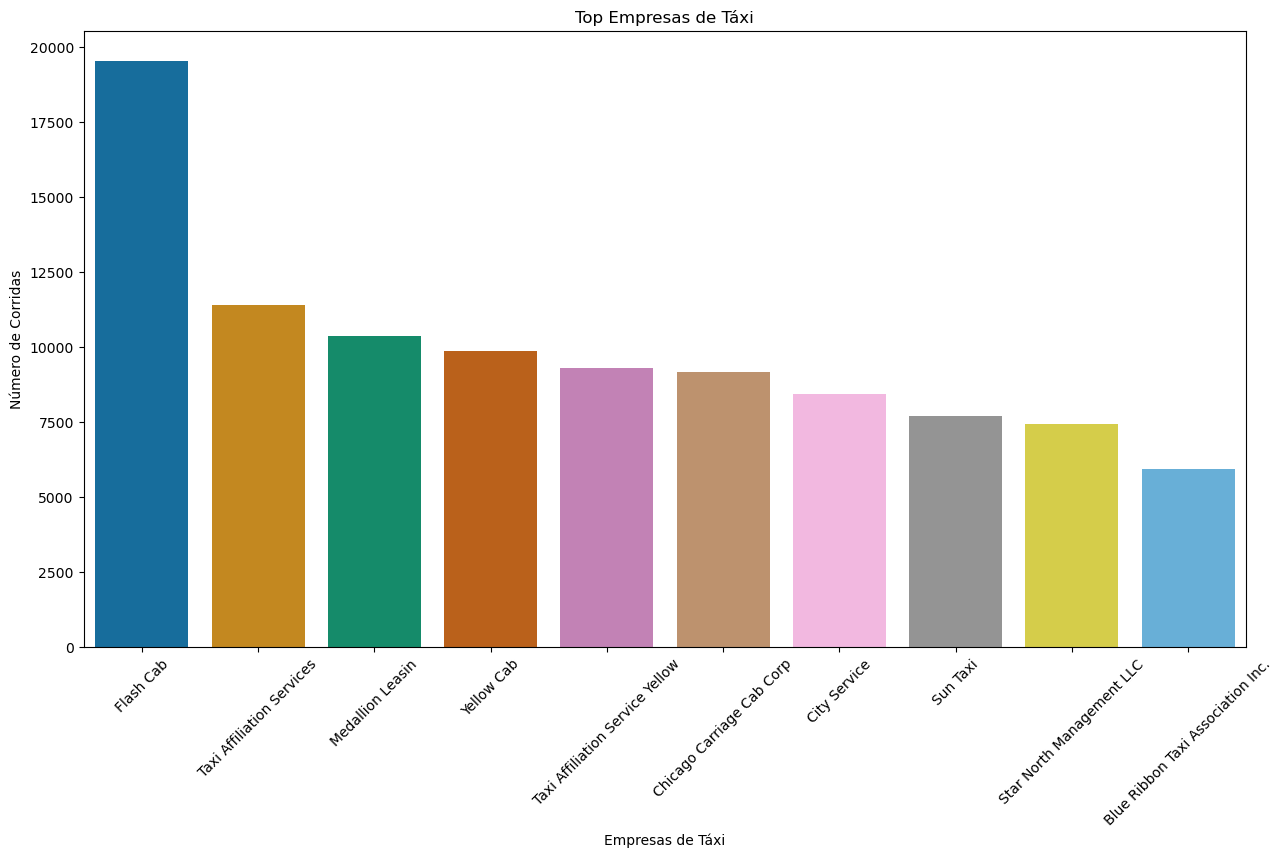

In [24]:
# Definindo o tamanho da figura do gráfico
plt.figure(figsize=(15, 8))  
# Criando um gráfico de barras usando Seaborn
sns.barplot(data=top_company, x='company_name', y='trips_amount', palette='colorblind')  
# Definindo  o título do gráfico
plt.title('Top Empresas de Táxi')  
# Definindo  o rótulo do eixo x
plt.xlabel('Empresas de Táxi') 
# Definindo  o rótulo do eixo y
plt.ylabel('Número de Corridas')  
# Definindo a rotação do eixo y
plt.xticks(rotation=45)
# Exibindo o gráfico
plt.show()  

Podemos observar o top 10 de empresas de que mais fazem viagem de Táxi em Chicago, sendo a mais popular a empresa 'Flash Cab'.

In [25]:
top_location = df_location.sort_values(by='average_trips', ascending=False).head(10)
top_location

,dropoff_location_name,average_trips
0,Loop,10727.466667
1,River North,9523.666667
2,Streeterville,6664.666667
3,West Loop,5163.666667
4,O'Hare,2546.900000
5,Lake View,2420.966667
6,Grant Park,2068.533333
7,Museum Campus,1510.000000
8,Gold Coast,1364.233333
9,Sheffield & DePaul,1259.766667


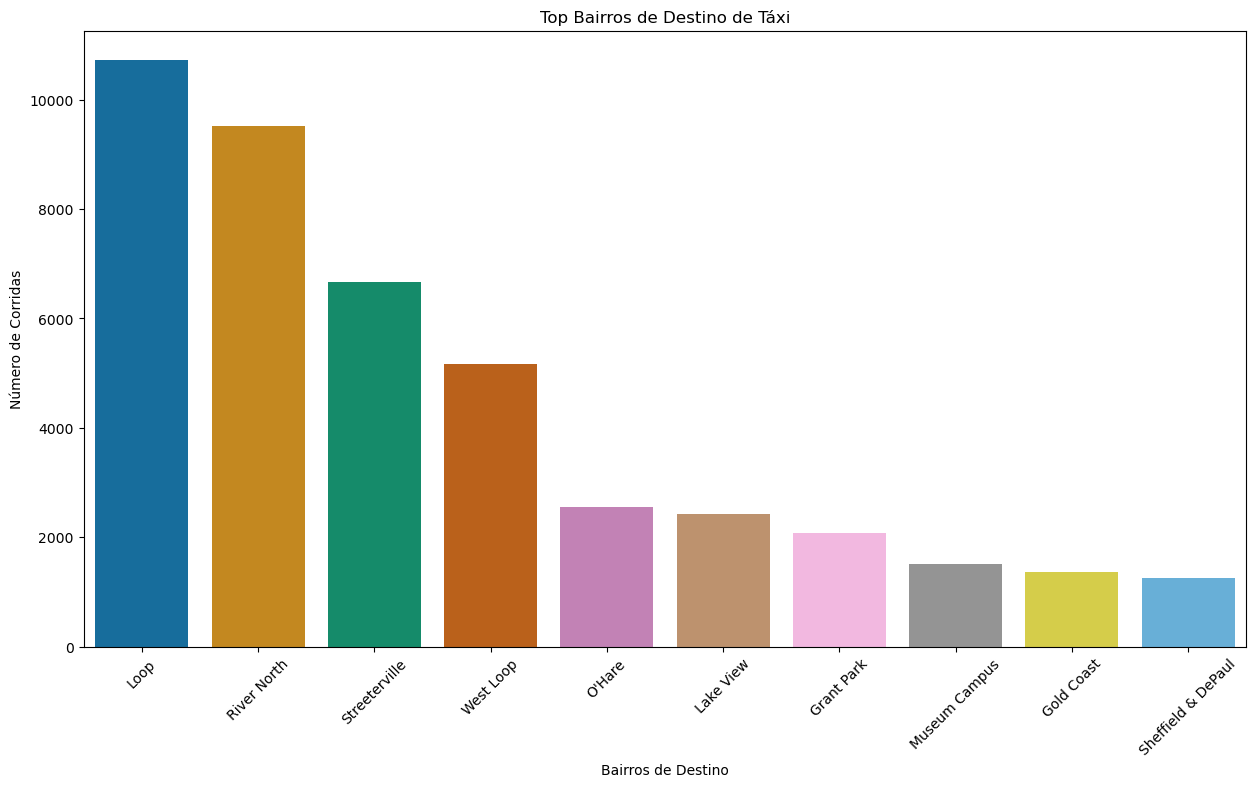

In [26]:
# Definindo o tamanho da figura do gráfico
plt.figure(figsize=(15, 8))
# Criando um gráfico de barras usando Seaborn
sns.barplot(data=top_location, x='dropoff_location_name', y='average_trips', palette='colorblind')
# Definindo  o título do gráfico
plt.title('Top Bairros de Destino de Táxi')
# Definindo  o rótulo do eixo x
plt.xlabel('Bairros de Destino')
# Definindo  o rótulo do eixo y
plt.ylabel('Número de Corridas')
# Definindo a rotação do eixo y
plt.xticks(rotation=45)
# Exibindo o gráfico
plt.show()


Podemos observar o top 10 de bairros de destinos que mais fazem viagem de Táxi em Chicago, sendo o bairro mais popular o 'Loop'.

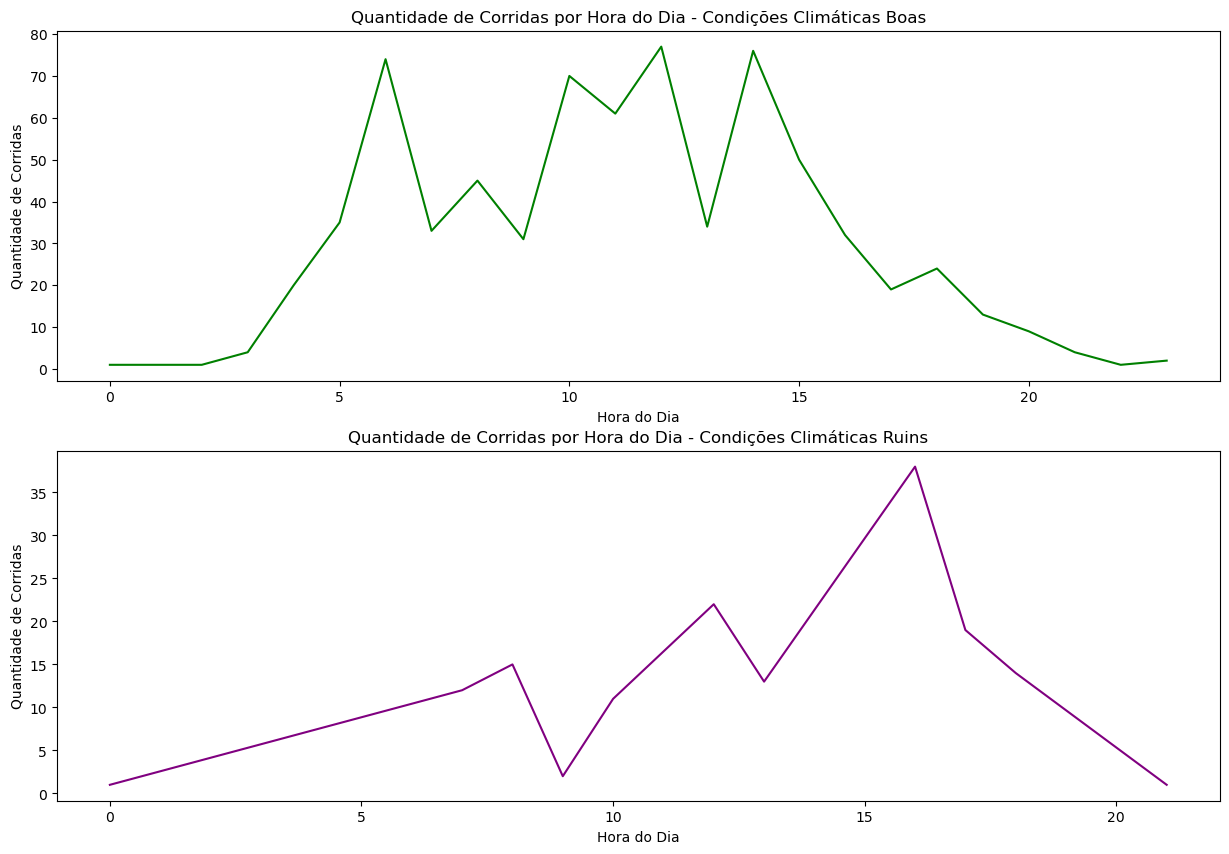

In [30]:
good_weather_hourly_counts = df_weather[df_weather['weather_conditions'] == 'Good']['start_ts'].dt.hour.value_counts().sort_index()
bad_weather_hourly_counts = df_weather[df_weather['weather_conditions'] == 'Bad']['start_ts'].dt.hour.value_counts().sort_index()

# Configurando o tamanho dos subplots
fig, axs = plt.subplots(2, figsize=(15, 10))

# Plot para condições climáticas boas
axs[0].plot(good_weather_hourly_counts.index, good_weather_hourly_counts.values, color='green')
axs[0].set_title('Quantidade de Corridas por Hora do Dia - Condições Climáticas Boas')
axs[0].set_xlabel('Hora do Dia')
axs[0].set_ylabel('Quantidade de Corridas')

# Plot para condições climáticas ruins
axs[1].plot(bad_weather_hourly_counts.index, bad_weather_hourly_counts.values, color='purple')
axs[1].set_title('Quantidade de Corridas por Hora do Dia - Condições Climáticas Ruins')
axs[1].set_xlabel('Hora do Dia')
axs[1].set_ylabel('Quantidade de Corridas')

plt.show()

Neste código, estamos agrupando os dados por hora do dia e condições climáticas (boas e ruins) e contando a quantidade de corridas em cada hora. Em seguida, configuramos o tamanho dos subplots para acomodar dois gráficos, um para as condições climáticas boas e outro para as condições climáticas ruins.

No primeiro gráfico, representamos a quantidade de corridas por hora do dia em condições climáticas boas, usando a cor verde para destacar os dados. O título do gráfico indica a informação visualizada, e os rótulos dos eixos x e y fornecem informações sobre os dados representados.

No segundo gráfico, fazemos o mesmo para as condições climáticas ruins, utilizando a cor roxa para diferenciar os dados. Novamente, o título e os rótulos dos eixos fornecem informações contextuais sobre os dados apresentados.



[Voltar ao Índice](#back)

## Etapa 5. Hipóteses <a id='hypothesys'></a>

### A duração média dos passeios do Loop para o Aeroporto Internacional O'Hare muda nos sábados chuvosos?
Hipotese Nula H0: As medias dos passeios do Loop para o Aeroporto Internacional O'Hare entre dias 'Good' e 'Bad' são iguais.

Hipotese Alternativa H1: As medias dos passeios do Loop para o Aeroporto Internacional O'Hare entre dias 'Good' e 'Bad' são diferentes.

In [31]:
df_weather_good = df_weather.query("weather_conditions == 'Good'")
df_weather_good

,start_ts,weather_conditions,duration_seconds
0,2017-11-25 16:00:00,Good,2410.0
1,2017-11-25 14:00:00,Good,1920.0
2,2017-11-25 12:00:00,Good,1543.0
3,2017-11-04 10:00:00,Good,2512.0
4,2017-11-11 07:00:00,Good,1440.0
...,...,...,...
1056,2017-11-04 12:00:00,Good,3275.0
1057,2017-11-04 12:00:00,Good,2492.0
1059,2017-11-11 10:00:00,Good,1303.0
1060,2017-11-04 14:00:00,Good,2700.0


In [32]:
df_weather_bad = df_weather.query("weather_conditions == 'Bad'")
df_weather_bad

,start_ts,weather_conditions,duration_seconds
6,2017-11-04 16:00:00,Bad,2969.0
30,2017-11-18 12:00:00,Bad,1980.0
34,2017-11-04 17:00:00,Bad,2460.0
51,2017-11-04 16:00:00,Bad,2760.0
52,2017-11-18 12:00:00,Bad,2460.0
...,...,...,...
1031,2017-11-18 12:00:00,Bad,2560.0
1032,2017-11-18 10:00:00,Bad,1908.0
1053,2017-11-18 12:00:00,Bad,2400.0
1061,2017-11-18 16:00:00,Bad,2186.0


In [33]:
alpha = 0.05

In [34]:
results_weather = st.ttest_ind(df_weather_good['duration_seconds'], df_weather_bad['duration_seconds'],equal_var = False)

In [35]:
print('p-value:', results_weather.pvalue)

p-value: 3.437304741904334e-07


In [36]:
if results_weather.pvalue < alpha:
    print("Nós rejeitamos a hipótese nula")
else:
    print("Nós não podemos rejeitar a hipótese nula")

Nós rejeitamos a hipótese nula


O valor-p nos diz que os valores da duração média dos passeios do Loop para o Aeroporto Internacional O'Hare muda nos sábados chuvosos,p-value: 3.437304741904334e-07 muito abaixo do nosso alpha que é 5%, concluimos que são diferentes, por isso nós rejeitamos a hipótese nula.

[Voltar ao Índice](#back)

## Conclusão geral <a id='end'></a>

"Durante este projeto, realizamos a importação das bibliotecas 'pandas' e 'numpy', que são comumente utilizadas, bem como as bibliotecas 'matplotlib' e 'seaborn' para a construção de gráficos, visando uma melhor visualização e compreensão do problema em questão.

Realizamos a coleta de dados a partir de fontes online, extraímos as informações e criamos nossos DataFrames. Utilizamos a linguagem SQL para filtrar e organizar os dados, visando uma preparação adequada para as etapas subsequentes.

A etapa de pré-processamento de dados envolveu a padronização de estilos em cada coluna, a correção de valores incongruentes, o preenchimento de valores ausentes com base em estudos sobre outras colunas devidamente preenchidas, a verificação de duplicatas na base de dados e a realização de estudos para determinar as preferências dos passageiros e o impacto de fatores externos nas corridas.

A partir da Análise Exploratória de Dados, pudemos concluir que a empresa mais popular é a Flash Cab e que o bairro com o maior número de viagens de destino é o Loop."

Espero que esteja de acordo com o que você precisa!